In [1]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence

df_chau    = pd.read_csv("chau.csv")
df_hola    = pd.read_csv("hola.csv")
df_gracias = pd.read_csv("gracias.csv")
df_chau["label"]    = "chau"
df_hola["label"]    = "hola"
df_gracias["label"] = "gracias"
max_seq_chau = df_chau["Secuencia"].max() 
df_hola["Secuencia"] = df_hola["Secuencia"] + max_seq_chau
max_seq_hola = df_hola["Secuencia"].max()
df_gracias["Secuencia"] = df_gracias["Secuencia"] + max_seq_hola
df_total = pd.concat([df_chau, df_hola, df_gracias], ignore_index=True)
grouped = df_total.groupby("Secuencia").apply(
    lambda x: torch.tensor(x[["X", "Y", "Z"]].values, dtype=torch.float32)
)

all_tensors = grouped.tolist() 
padded = pad_sequence(all_tensors, batch_first=True)

num_sequences = padded.shape[0]
max_len = padded.shape[1]

if max_len % 21 != 0:
    raise ValueError(
        "La secuencia más larga no es múltiplo de 21. "
        "Verifica que tus datos estén ordenados y agrupen 21 puntos por frame."
    )

T_max = max_len // 21
padded = padded.reshape(num_sequences, T_max, 21, 3)
print("Forma final de las secuencias:", padded.shape)
labels = df_total.groupby("Secuencia")["label"].first().tolist()
print("Ejemplo de etiquetas:", labels)
label_map = {"chau": 0, "hola": 1, "gracias": 2}
y_total = [label_map[l] for l in labels]
y_total = torch.tensor(y_total, dtype=torch.long)
indices = torch.randperm(num_sequences)
train_size = int(0.8 * num_sequences)
train_indices = indices[:train_size]
val_indices   = indices[train_size:]

X_train = padded[train_indices]
y_train = y_total[train_indices]
X_val   = padded[val_indices]
y_val   = y_total[val_indices]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

Forma final de las secuencias: torch.Size([55, 133, 21, 3])
Ejemplo de etiquetas: ['chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'chau', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'hola', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias', 'gracias']
X_train shape: torch.Size([44, 133, 21, 3])
y_train shape: torch.Size([44])
X_val shape: torch.Size([11, 133, 21, 3])
y_val shape: torch.Size([11])


C:\Users\sorac\AppData\Local\Temp\ipykernel_15600\2968384753.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_total.groupby("Secuencia").apply(


,Secuencia,Mano,Punto,X,Y,Z,label
0,1,Derecha,0,0.193509,0.916309,1.562929e-07,chau
1,1,Derecha,1,0.247191,0.919252,-3.174349e-03,chau
2,1,Derecha,2,0.299474,0.905067,-1.362301e-02,chau
3,1,Derecha,3,0.343559,0.896575,-2.491510e-02,chau
4,1,Derecha,4,0.372926,0.887576,-3.939677e-02,chau
...,...,...,...,...,...,...,...
25405,16,Izquierda,16,0.495591,0.905821,-8.143111e-02,chau
25406,16,Izquierda,17,0.529466,1.029239,-5.783628e-02,chau
25407,16,Izquierda,18,0.536592,1.006084,-7.537854e-02,chau
25408,16,Izquierda,19,0.539670,0.985539,-8.088870e-02,chau


# Arquitectura por defecto de STGCN

In [252]:
num_points_per_frame = 21

adjacency_matrix = np.zeros((num_points_per_frame, num_points_per_frame), dtype=int)
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (5, 9) , (9, 10), (10, 11), (11, 12),
    (9, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20),
    (13, 17)
]
for edge in edges:
    adjacency_matrix[edge[0], edge[1]] = 1
    adjacency_matrix[edge[1], edge[0]] = 1

In [253]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, X, A):
        batch_size, num_nodes, in_features, time_steps = X.shape

        X = X.permute(0, 3, 1, 2)  # (batch_size, time_steps, num_nodes, in_features)
        X = X.reshape(batch_size * time_steps, num_nodes, in_features)

        if A.ndim == 2:
            # Caso A fija para todos
            A = A.unsqueeze(0).expand(batch_size, -1, -1)
            A = A.repeat(time_steps, 1, 1)
        elif A.ndim == 3:
            # Caso A viene con forma (batch_size, num_nodes, num_nodes)
            # Hay que expandirla al eje del tiempo
            # => (batch_size, time_steps, num_nodes, num_nodes)
            A = A.unsqueeze(1).expand(-1, time_steps, -1, -1)
            # => (batch_size * time_steps, num_nodes, num_nodes)
            A = A.reshape(batch_size * time_steps, num_nodes, num_nodes)
        else:
            raise ValueError("Dimensión de A no soportada.")

        # Multiplicación batch-wise
        out = torch.bmm(A, X)
        out = self.fc(out)

        # Restaurar dimensiones
        out = out.reshape(batch_size, time_steps, num_nodes, -1)
        return out.permute(0, 2, 3, 1)


class TemporalConv(nn.Module):
    """
    Temporal convolution using Conv1D.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConv, self).__init__()
        self.conv1d = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size // 2, 0))

    def forward(self, X):
        """
        Args:
        - X: (batch_size, num_nodes, in_channels, time_steps)
        """
        X = X.permute(0, 2, 1, 3)  # (batch_size, in_channels, num_nodes, time_steps)
        out = self.conv1d(X)  # Apply temporal convolution
        return out.permute(0, 2, 1, 3)  # Back to (batch_size, num_nodes, out_channels, time_steps)


class STBlock(nn.Module):
    """
    Spatio-Temporal Block: Combines temporal and spatial convolutions.
    """
    def __init__(self, in_channels, out_channels, num_nodes, kernel_size=3):
        super(STBlock, self).__init__()
        self.temporal1 = TemporalConv(in_channels, out_channels, kernel_size)
        self.graph_conv = GraphConv(out_channels, out_channels)
        self.temporal2 = TemporalConv(out_channels, out_channels, kernel_size)
        self.norm = nn.LayerNorm([out_channels, num_nodes])  # Normalize along features and nodes

    def forward(self, X, A):
        """
        Args:
        - X: (batch_size, num_nodes, in_channels, time_steps)
        - A: (num_nodes, num_nodes)
        """
        out = F.relu(self.temporal1(X))
        out = self.graph_conv(out, A)
        out = self.temporal2(out)
        out = out.permute(0, 3, 2, 1)  # (batch_size, time_steps, features, nodes)
        out = self.norm(out)  # Normalize features and nodes
        return out.permute(0, 3, 2, 1)  # Back to (batch_size, num_nodes, features, time_steps)


class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, num_classes, kernel_size=3):
        super(STGCN, self).__init__()
        self.block1 = STBlock(in_channels, hidden_channels, num_nodes, kernel_size)
        self.block2 = STBlock(hidden_channels, hidden_channels, num_nodes, kernel_size)
        self.fc = nn.Linear(hidden_channels, num_classes)  # Salida con el número de clases
        self.num_nodes = num_nodes

    def forward(self, X, A):
        """
        Args:
        - X: (batch_size, num_frames, num_nodes, num_features) --> Ajustado a (batch_size, num_nodes, num_features, num_frames)
        - A: (num_nodes, num_nodes)
        """
        # Ajustar dimensiones de entrada
        X = X.permute(0, 2, 3, 1)  # (batch_size, num_nodes, num_features, num_frames)
        
        # Pasar por bloques STGCN
        out = self.block1(X, A)
        out = self.block2(out, A)
        
        # Pooling sobre nodos y tiempo
        out = out.mean(dim=1)  # (batch_size, num_features, time_steps)
        out = out.mean(dim=-1)  # (batch_size, hidden_channels)

        # Clasificación final
        out = self.fc(out)  # (batch_size, num_classes)
        return out


from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, X_data, y_data, adjacency_matrix):
        """
        Args:
        - X_data: Tensor con forma (num_sequences, num_frames, num_nodes, num_features)
        - y_data: Lista de etiquetas con forma (num_sequences,)
        - adjacency_matrix: Matriz de adyacencia con forma (num_nodes, num_nodes)
        """
        self.X_data = torch.tensor(X_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)
        self.adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        """
        Devuelve los datos de entrada y etiqueta para un índice específico.
        """
        X = self.X_data[idx]  # (num_frames, num_nodes, num_features)
        y = self.y_data[idx]  # Etiqueta
        A = self.adjacency_matrix  # Matriz de adyacencia (constante para todos)
        return X, y, A



In [254]:
from torch.utils.data import DataLoader
import torch.optim as optim


dataset = SequenceDataset(X_train, y_train, adjacency_matrix)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

num_nodes = 21
num_features = 3
hidden_channels = 64 * 3
num_classes = 3  # Hola / Chau / gracias
model = STGCN(num_nodes, num_features, hidden_channels, num_classes)

C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\3390574583.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_data = torch.tensor(X_data, dtype=torch.float32)
C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\3390574583.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_data = torch.tensor(y_data, dtype=torch.long)


In [255]:
# Simular un lote del DataLoader
for X_batch, y_batch, A_batch in dataloader:
    print("Forma de X_batch:", X_batch.shape)  # (batch_size, num_frames, num_nodes, num_features)
    print("Forma de y_batch:", y_batch.shape)  # (batch_size,)
    print("Forma de A_batch:", A_batch.shape)  # (num_nodes, num_nodes)
    print(y_batch)
    
    y_pred = model(X_batch, A_batch)  # Forward pass
    print("Forward pass exitoso!")
    print("Forma de salida (y_pred):", y_pred.shape)  # (batch_size, num_classes)
    
    break  # Solo probar un lote


Forma de X_batch: torch.Size([4, 22, 21, 3])
Forma de y_batch: torch.Size([4])
Forma de A_batch: torch.Size([4, 21, 21])
tensor([2, 0, 1, 1])
Forward pass exitoso!
Forma de salida (y_pred): torch.Size([4, 3])


In [256]:
train_dataset = SequenceDataset(X_train, y_train, adjacency_matrix) 
val_dataset = SequenceDataset(X_val, y_val, adjacency_matrix)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\3390574583.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_data = torch.tensor(X_data, dtype=torch.float32)
C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\3390574583.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_data = torch.tensor(y_data, dtype=torch.long)


In [265]:
import torch.nn as nn
import torch.optim as optim

num_nodes = 21
num_features = 3
hidden_channels = 64 * 5
num_classes = 3 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = STGCN(num_nodes, num_features, hidden_channels, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [258]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch, A_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            A_batch = A_batch.to(device)

            outputs = model(X_batch, A_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)
    
    return val_loss, all_preds, all_labels


In [266]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch, A_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        A_batch = A_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch, A_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_loss:.4f}  |  Val Loss: {val_loss:.4f}")

print("\n--- Resultados en Validación (final) ---")
print(classification_report(val_labels, val_preds))
print("Matriz de Confusión:")
print(confusion_matrix(val_labels, val_preds))


Epoch [1/200]: Train Loss: 1.4623  |  Val Loss: 1.1430
Epoch [2/200]: Train Loss: 1.1592  |  Val Loss: 1.1073
Epoch [3/200]: Train Loss: 1.1947  |  Val Loss: 1.1080
Epoch [4/200]: Train Loss: 1.1674  |  Val Loss: 1.1013
Epoch [5/200]: Train Loss: 1.1441  |  Val Loss: 1.1626
Epoch [6/200]: Train Loss: 1.1928  |  Val Loss: 1.1212
Epoch [7/200]: Train Loss: 1.1477  |  Val Loss: 1.1443
Epoch [8/200]: Train Loss: 1.1258  |  Val Loss: 1.1096
Epoch [9/200]: Train Loss: 1.1179  |  Val Loss: 1.3034
Epoch [10/200]: Train Loss: 1.1648  |  Val Loss: 1.1020
Epoch [11/200]: Train Loss: 1.1108  |  Val Loss: 1.1061
Epoch [12/200]: Train Loss: 1.1163  |  Val Loss: 1.0857
Epoch [13/200]: Train Loss: 1.1037  |  Val Loss: 1.0878
Epoch [14/200]: Train Loss: 1.0771  |  Val Loss: 1.0941
Epoch [15/200]: Train Loss: 1.0664  |  Val Loss: 1.1006
Epoch [16/200]: Train Loss: 1.0706  |  Val Loss: 1.1007
Epoch [17/200]: Train Loss: 1.0688  |  Val Loss: 1.1086
Epoch [18/200]: Train Loss: 1.0768  |  Val Loss: 1.1095
E

# Predict Sequences

In [260]:
import torch
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

def predict_sequences(model, csv_path, adjacency_matrix, label_map, device):
    """
    Lee un CSV con columnas [Secuencia, X, Y, Z],
    agrupa cada secuencia, hace padding y obtiene predicciones del modelo.
    
    Args:
        model: modelo PyTorch entrenado (p.ej. STGCN).
        csv_path: ruta al CSV a predecir.
        adjacency_matrix: tensor (21, 21) usado en tu modelo.
        label_map: diccionario, p.ej. {"chau": 0, "hola": 1, "gracias": 2}.
        device: torch.device("cuda" o "cpu").
    
    Returns:
        Un diccionario {id_secuencia: clase_predicha_str}.
    """
    # 1) Cargar CSV
    df_test = pd.read_csv(csv_path)
    
    # 2) Agrupar por secuencia y convertir a Tensor
    grouped_test = df_test.groupby("Secuencia").apply(
        lambda x: torch.tensor(x[["X", "Y", "Z"]].values, dtype=torch.float32)
    )
    # grouped_test es un Series donde cada elemento (fila) es un Tensor (num_filas, 3)

    # 3) Hacer una lista con los tensores y aplicar pad_sequence
    test_tensors = grouped_test.tolist()  # Lista de tensores
    padded_test = pad_sequence(test_tensors, batch_first=True)
    # => (num_secuencias, max_len, 3)

    # 4) max_len debería ser (num_frames * 21). Verificamos y re-damos forma.
    num_sequences = len(test_tensors)
    max_len_test = padded_test.shape[1]
    if max_len_test % 21 != 0:
        raise ValueError(
            "La secuencia más larga no es múltiplo de 21. "
            "Revisa la consistencia de tus datos (21 puntos por frame)."
        )
    T_max = max_len_test // 21  # número de frames
    
    # 5) Redimensionar a (num_secuencias, T_max, 21, 3)
    padded_test = padded_test.reshape(num_sequences, T_max, 21, 3).to(device)

    # 6) Pasar por el modelo en modo evaluación
    model.eval()
    with torch.no_grad():
        # Expande la matriz de adyacencia para tener (num_secuencias, 21, 21)
        # En caso tu STGCN requiera 'A' con batch_size = num_secuencias
        A_batch = adjacency_matrix.unsqueeze(0).repeat(num_sequences, 1, 1).to(device)
        
        outputs = model(padded_test, A_batch)  # (num_secuencias, num_clases)
        preds = outputs.argmax(dim=1)          # (num_secuencias,)

    # 7) Convertir índices predichos a nombres de clase
    inv_label_map = {v: k for k, v in label_map.items()}  # inverso, ej: {0:"chau", 1:"hola", 2:"gracias"}
    preds_names = [inv_label_map[p.item()] for p in preds]

    # 8) Emparejar IDs de secuencia con la predicción
    sequence_ids = grouped_test.index.tolist()  # IDs de secuencia en el mismo orden que 'padded_test'
    results = dict(zip(sequence_ids, preds_names))
    
    return results


# Inferencias

In [262]:
import cv2
import mediapipe as mp
import csv


mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils


cap = cv2.VideoCapture(0)
capturing = False
sequence_id = 0 

with open('datos_manos.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Secuencia', 'Mano', 'Punto', 'X', 'Y', 'Z'])

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

            if results.right_hand_landmarks or results.left_hand_landmarks:
                if not capturing:
                    sequence_id += 1 
                    print(f"Manos detectadas: comenzando a capturar datos para la secuencia {sequence_id}...")
                    capturing = True

                if results.right_hand_landmarks:
                    for idx, landmark in enumerate(results.right_hand_landmarks.landmark):
                        writer.writerow([sequence_id, 'Derecha', idx, landmark.x, landmark.y, landmark.z])

                if results.left_hand_landmarks:
                    for idx, landmark in enumerate(results.left_hand_landmarks.landmark):
                        writer.writerow([sequence_id, 'Izquierda', idx, landmark.x, landmark.y, landmark.z])

            else:
                if capturing:
                    print(f"Manos no detectadas: deteniendo la captura de la secuencia {sequence_id}...")
                    capturing = False

            cv2.imshow('Video desde PC - Holistic', image)
            
            if cv2.waitKey(1) & 0xFF == ord('q'): # Salir con la tecla 'q'
                break

cap.release()
cv2.destroyAllWindows()

Manos detectadas: comenzando a capturar datos para la secuencia 1...
Manos no detectadas: deteniendo la captura de la secuencia 1...
Manos detectadas: comenzando a capturar datos para la secuencia 2...
Manos no detectadas: deteniendo la captura de la secuencia 2...
Manos detectadas: comenzando a capturar datos para la secuencia 3...
Manos no detectadas: deteniendo la captura de la secuencia 3...
Manos detectadas: comenzando a capturar datos para la secuencia 4...
Manos no detectadas: deteniendo la captura de la secuencia 4...
Manos detectadas: comenzando a capturar datos para la secuencia 5...
Manos no detectadas: deteniendo la captura de la secuencia 5...
Manos detectadas: comenzando a capturar datos para la secuencia 6...
Manos no detectadas: deteniendo la captura de la secuencia 6...
Manos detectadas: comenzando a capturar datos para la secuencia 7...
Manos no detectadas: deteniendo la captura de la secuencia 7...
Manos detectadas: comenzando a capturar datos para la secuencia 8...


# Pruebas a tiempo real

In [267]:
import torch

adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
adjacency_matrix = adjacency_matrix.to(device)

test_csv_path = "test_chau.csv" 
predicciones = predict_sequences(
    model,
    test_csv_path,
    adjacency_matrix,
    label_map,
    device
)

for seq_id, clase_pred in predicciones.items():
    print(f"Secuencia {seq_id} -> predicción: {clase_pred}")


Secuencia 1 -> predicción: chau
Secuencia 2 -> predicción: chau
Secuencia 3 -> predicción: chau
Secuencia 4 -> predicción: chau
Secuencia 5 -> predicción: chau
Secuencia 6 -> predicción: chau
Secuencia 7 -> predicción: chau
Secuencia 8 -> predicción: chau
Secuencia 9 -> predicción: chau
Secuencia 10 -> predicción: chau
Secuencia 11 -> predicción: chau
Secuencia 12 -> predicción: chau
Secuencia 13 -> predicción: chau
Secuencia 14 -> predicción: chau


C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\1166589002.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
C:\Users\sorac\AppData\Local\Temp\ipykernel_17488\2817061340.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_test = df_test.groupby("Secuencia").apply(


In [269]:
preds = pd.DataFrame(predicciones.items(), columns=["Secuencia", "Clase Predicha"])

<Axes: title={'center': 'Predicciones'}, xlabel='Clase Predicha'>

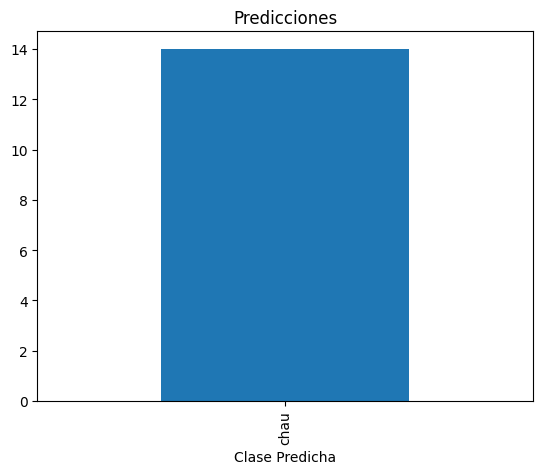

In [270]:
preds["Clase Predicha"].value_counts().plot(kind="bar", title="Predicciones")